In [13]:
from matplotlib import pyplot as plt
import platform, os, sys, pprint, h5py, emoji
import numpy as np
from glob import glob
from tabulate import tabulate
from pprint import pprint
from importlib import reload

if 'Windows' in platform.system():
    sys.path.append(r'C:\Users\slab\Documents\Code')
    sys.path.append(r'D:\BEMPP_shared\Modules')
    import interpolate_slow
else:
    sys.path.append("/Users/gkoolstra/Documents/Code")
    from BEMHelper import interpolate_slow
    
from Common import common, kfit
from TrapAnalysis import trap_analysis
from TrapAnalysis import artificial_anneal as anneal

%matplotlib inline
%config InlineBackend.figure_format='retina'

In [106]:
save_path = r"/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/2D Plot"
#sub_dirs = [r"170227_092528_M018V5_Greater_Trap_Area_resonator_sweep"]
sub_dirs = glob(save_path+"/*trap_sweep*")[:-1]
pprint(sub_dirs)

['/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/2D Plot/170228_164038_M018V5_Greater_Trap_Area_trap_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/2D Plot/170228_180540_M018V5_Greater_Trap_Area_trap_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/2D Plot/170228_191658_M018V5_Greater_Trap_Area_trap_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/2D Plot/170228_203015_M018V5_Greater_Trap_Area_trap_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/2D Plot/170228_214313_M018V5_Greater_Trap_Area_trap_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/2D Plot/170228_225405_M018V5_Greater_Trap_Area_trap_sweep',
 '/Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic '
 'potential/2D Plot/170301_001307_M0

In [107]:
def get_trapped_electrons(r, trap_area_x=(-1E-6, 1E-6)):
    """
    Evaluate how many electrons are in the area specified by the bounds trap_area_x[0] < x < trap_area_x[1]
    :param r: r = np.array([x0, y0, x1, y1, x2, y2, ... , xN, yN])
    :param trap_area_x: Tuple specifying the bounds of the trapping area
    :return: The number of electrons in the trapping area (scalar)
    """
    return len(np.where(np.logical_and(r[::2] > trap_area_x[0], r[::2] < trap_area_x[1]))[0])

In [109]:
dbin = 0.006E-6
bins = np.arange(-0.80E-6, 0.80E-6+dbin, dbin)
save = False

N_electrons  = list()
noof_rows = np.zeros((196, len(sub_dirs)))

for N_axis, sub_dir in enumerate(sub_dirs):
    converged, energy, num_trapped_electrons = list(), list(), list()
    with h5py.File(os.path.join(os.path.join(save_path, sub_dir), "Results.h5"), "r") as f:
        print("Directory: %s" % sub_dir)
        k = 0
        for step in f.keys():
            if "step" in step:
                electron_ri = f[step + "/electron_final_coordinates"][()]
                xi, yi = anneal.r2xy(electron_ri)
                energy.append(f[step+"/energy"][()])
                num_trapped_electrons.append(get_trapped_electrons(electron_ri, trap_area_x=(-1E-6, 1E-6)))

                valid_solution = f[step + "/solution_converged"][()]
                converged.append(valid_solution)

                if valid_solution:
                    electron_hist, bin_edges = np.histogram(xi, bins=bins)
                else:
                    electron_hist = np.zeros(len(electron_hist))

                if k == 0:
                    electron_histogram = electron_hist
                else:
                    electron_histogram = np.vstack((electron_histogram, electron_hist))

                k += 1
        N_elecs = np.sum(electron_histogram[0,:])
        N_electrons.append(N_elecs)
        N_threshold = 10
        num_peaks = list()
        for V_axis in range(np.shape(electron_histogram)[0]):
            peakind = np.where(electron_histogram[V_axis,:] > N_threshold)[0]
            peakind = np.delete(peakind, np.where(np.diff(peakind) == 1))
            num_peaks.append(len(peakind))
            noof_rows[V_axis, N_axis] = len(peakind)
        
        ## NOTE NOTE NOTE (REMOVE :50 )
        Vtrap = f["Vtrap"][()][:40]
        Vres = f["Vres"][()]
        xpoints = f["xpoints"][()]
        #plt.plot(Vtrap, num_trapped_electrons, label="Vres=%.2fV"%(Vres))
        #print(np.shape(Vtrap))
        
        if N_axis == 0:
            Vtraps = Vtrap
            Vress = Vres * np.ones(len(Vtrap))
            twodplot = np.array(num_trapped_electrons)
        else:
            Vtraps = np.vstack((Vtraps, Vtrap))
            Vress = np.vstack((Vress, Vres * np.ones(len(Vtrap))))
            ## NOTE NOTE NOTE (REMOVE :50 )
            twodplot = np.vstack((twodplot, np.array(num_trapped_electrons[:40])))

    print("\tOut of %d simulations, %d did not converge..." % (len(Vtrap), len(Vtrap) - np.sum(converged)))

#plt.legend(prop={"size": 8})

Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/2D Plot/170228_164038_M018V5_Greater_Trap_Area_trap_sweep
	Out of 40 simulations, 0 did not converge...
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/2D Plot/170228_180540_M018V5_Greater_Trap_Area_trap_sweep
	Out of 40 simulations, -1 did not converge...
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/2D Plot/170228_191658_M018V5_Greater_Trap_Area_trap_sweep
	Out of 40 simulations, 0 did not converge...
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/2D Plot/170228_203015_M018V5_Greater_Trap_Area_trap_sweep
	Out of 40 simulations, -1 did not converge...
Directory: /Volumes/slab/Gerwin/Electron on helium/Electron optimization/Realistic potential/2D Plot/170228_214313_M018V5_Greater_Trap_Area_trap_sweep
	Out of 40 simulations, 0 did not converge...
Directory: /V

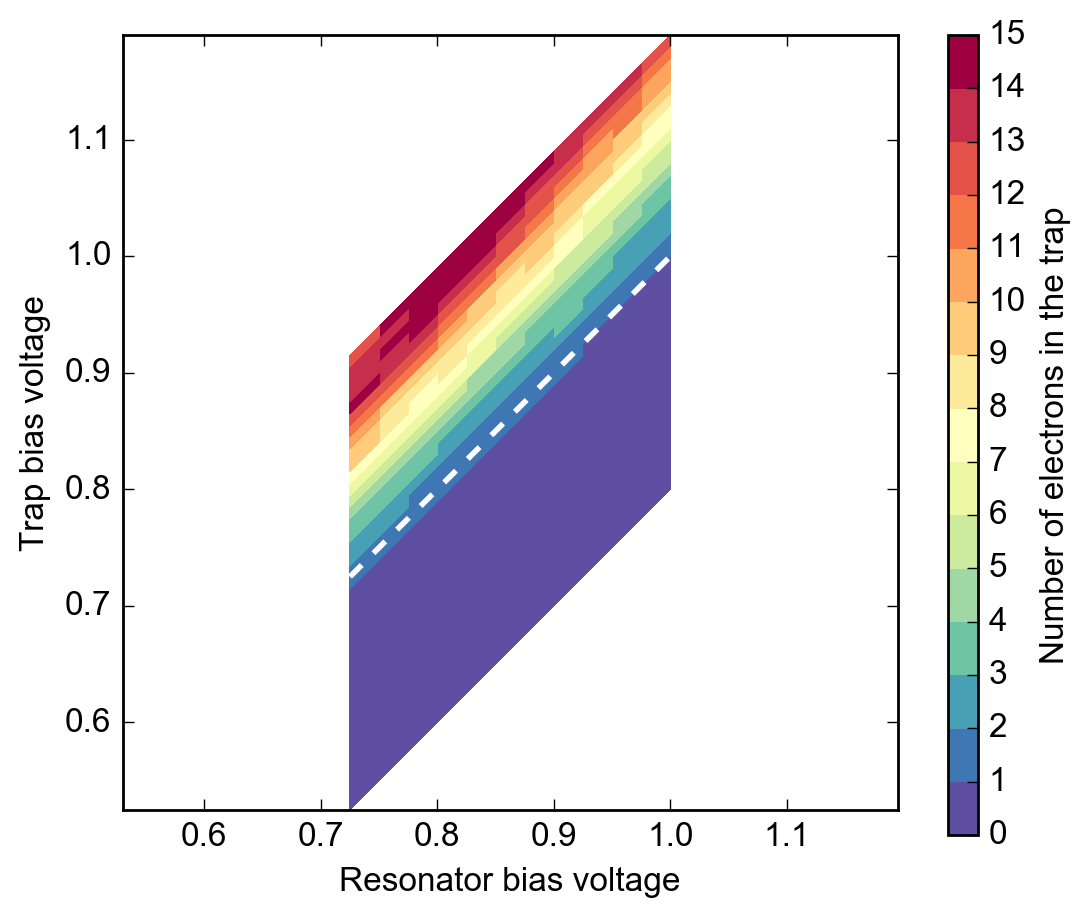

In [110]:
guide = np.linspace(np.min(Vress), np.max(Vress), 101)
import matplotlib

# define the colormap
cmap = plt.cm.Spectral_r
# extract all colors from the .jet map
cmaplist = [cmap(i) for i in range(cmap.N)]
# force the first color entry to be grey
#cmaplist[0] = (.5,.5,.5,1.0)
# create the new map
cmap = cmap.from_list('Custom cmap', cmaplist, cmap.N)

# define the bins and normalize
bounds = np.arange(0, np.max(twodplot)+1)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(5.,5.))
common.configure_axes(12)
plt.pcolormesh(Vress, Vtraps, twodplot, cmap=cmap, norm=norm)
plt.xlim(np.min(Vress), np.max(Vress))
plt.ylim(np.min(Vtraps), np.max(Vtraps))
plt.plot(guide, guide, '--', lw=2.0, color='white')
plt.axes().set_aspect('equal', 'datalim')
plt.ylabel("Trap bias voltage")
plt.xlabel("Resonator bias voltage")

# create a second axes for the colorbar
ax2 = fig.add_axes([0.95, 0.1, 0.03, 0.8])
cb = matplotlib.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, spacing='proportional', 
                                      ticks=bounds, boundaries=bounds, format='%1i')
ax2.set_ylabel('Number of electrons in the trap', size=12)

In [111]:
emoji.emojize("This is fucking hard ... :sweat:", use_aliases=True)

'This is fucking hard ... 😓'